In [17]:
import pandas as pd;
import random;
from statistics import fmean, stdev;

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import DistanceMetric
from sklearn.ensemble import RandomForestClassifier

OBJECTS/VARIABLES:

Antibody - list of Numerical values (Reals?) , represented by a row of a dataframe?
Population - List[Antibodies], represented by the total dataframe?

Target Size (i.e number of antibodies to be created) = (Size of Majority Class) - (Size of minority class)



FUNCTIONS:

Initializing :- input: original dataframe

                         do: Get bounds of minority class by taking the highest and lowest values in each of the [n] dimensions

                         How: Do we take the whole minority class? or do we sample part or parts of it to generate our bounds. 

                         output: Upper and lower bounds of the minority class


Creation :- Input: Bounds of the min class

        do: Create a set of antibodies

        input: minority Dataframe 

        How:
            Possibilities:
            (As the Malhanabois paper does it) Take a random value between the bounds of the minority class feature as the datapoint

            (Nikhil Just sample minority class based on imbalance rate (doesn't require bounds)

            (Adam) Take a random value, as in the paper's method, but off of a weighted curve? as in we could randomize, 
                but add some preference for values close to the boundary, or close to the center, etc.
                        -We could set this as a parameter, bell curve, linear. This same function could be a parameter in the mutation stage.
                        -If the density within the bounds is concentrated on one side, add bias towards that side in the random value;
        
        Challenges: 
            How do we deal with the different data categories (e.g nominal, ordinal, and continuous)? Continuous is easy, just a number in a range. Ordinal is ???, nominal is difficult, even if one-hot encoded, we might random to have two values that should be exclusive (e.g an item being both blue and red). How do other imputation algorithms work with these problems? DO they even work with these problems?
        output: Initial Population as a DF?



**Initialization**

In [18]:

df = pd.read_csv("./Data/GeneratedSyntheticData-NosielessInformativeEasy.csv")

columns = df.columns.to_list()
columns_drop = columns.pop(-1)

#drop NaN rows, could implement imputer as well
df.dropna(inplace=True)

labels = df.drop(columns, axis=1)

#df= df.drop("5", axis=1)
#df= df.drop("Unnamed: 0", axis=1)

df

,0,1,2,3,4,5
0,-4.539317,5.021729,-7.042357,-7.428090,4.943687,0.0
1,4.300671,6.131065,-6.394796,-5.981102,4.579452,1.0
2,-5.004336,4.473384,-6.048647,-5.556982,4.051438,0.0
3,2.732848,7.791876,-7.495527,-6.541127,3.910933,1.0
4,-4.193859,5.393440,-5.317542,-5.605152,4.807354,0.0
...,...,...,...,...,...,...
295,5.349610,4.226061,-4.841005,-6.342083,4.820905,1.0
296,-5.247255,5.149173,-6.669314,-5.848687,3.793496,0.0
297,3.308685,5.513754,-3.805559,-5.564981,4.670373,1.0
298,-4.510472,4.712267,-4.550419,-3.915542,4.798225,0.0


In [19]:

count_nan = df.isnull().sum()
count_nan


0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [20]:
#TODO Gaussian generation can be optimized by altering how the loops work, putting the col loop on the outside and pre-generated fmean, stdev for the col
        #Currently it generates those values for every antibody
        

def get_bounds(minorityDF) -> dict:
    out = {}
    for col in minorityDF:
        colMax = df[col].max()
        colMin = df[col].min()
        out[col] = (colMin, colMax)
    return out

#This only works for continuous values. We will have to code a version for binary fields (We assume any categorical columns have been encoded)

####### Creation ################
# minorityDF - dataframe containing the minority class
# totalPopulation - The total number of antibodies to create
# weightingFunction - Can choose between uniform, triangular, ...
# mode - for use with a triangular function - set to the percentage of the range you wish to be most represented (between 0.0 and 1.0)
def Creation(minorityDF, totalPopulation : int, binaryColumns : list, weightingFunction : str = "uniform", mode : float = 0.5): 
    
    if(minorityDF.isnull().values.any()):
        raise ValueError("Minority Class DataFrame contains NaN")
    
    population = [] #Initializing the empty population
    if mode < 0.0 or mode > 1:
        raise Exception("mode must be between float value between 0.0 and 1.0")
    
    if weightingFunction not in ('uniform', 'triangular', 'gaussian'):
        raise Exception("Unknown function chosen, please use one of 'uniform', 'triangular', or 'gaussian'")

    bounds = get_bounds(minorityDF)
    
    if weightingFunction in ["uniform", "triangular"]: #If Generating via uniform or triangular distribution, loop through bounds of columns
        for i in range(totalPopulation): #For every antibody to be created

            antibody = [] #Initializing a single antibody
            for key,bnd in bounds.items(): #Iterate through the columns/dimensions/features of the minority class for each antibody 
                if key in binaryColumns:
                    antibody += [random.randint(int(bnd[0]),int(bnd[1]))]
                else:
                    if weightingFunction == "uniform":
                        antibody += [round(random.uniform(bnd[0],bnd[1]),4)] #Add a random value between the lower and upper bounds to the antibody

                    elif (weightingFunction == "triangular"):
                        
                        tri_tip = ( ((bnd[1]-bnd[0]) * mode) + bnd[0] ) #multiplying the difference by the percentage, plus the low bound gives us the point between the two, but percentile

                        if tri_tip < bnd[0]: #Error checks to make sure that the emphasized point isn't outside the bounds
                            tri_tip = bnd[0]
                        elif tri_tip > bnd[1]:
                            tri_tip = bnd[1]

                        antibody += [round( random.triangular(bnd[0],bnd[1], tri_tip), 5)]

            population+=[antibody] #add the created antibody to the population

    elif (weightingFunction == 'gaussian'): #If Generating via Gaussian, loop through columns of dataframe

        for i in range(totalPopulation): #For every antibody to be created

            antibody = [] #Initializing a single antibody
            for bnd in minorityDF: #Iterate over columns in the dataframe
                values = minorityDF[bnd].tolist() #convert series to list
                if bnd in binaryColumns:
                    antibody += [random.randint(bounds[bnd][0],bounds[bnd][1])]
                else:
                    antibody += [round(random.gauss(fmean(values) , stdev(values)), 5)] #using median and stdeviation of values, radomize over gauss

        
            population+=[antibody] #add the created antibody to the population

            
    popDF = pd.DataFrame(population, columns = minorityDF.columns.values)
    return popDF, bounds
    

#Creation(df,1000,['5'], weightingFunction='gaussian')


the range of col 0 is -7.383115828117358 - 6.878797831621593 
the range of col 1 is 1.3784551428757643 - 8.921792758996698 
the range of col 2 is -8.96569044205265 - -1.4396538279474047 
the range of col 3 is -8.360981787321295 - -1.4833255919669748 
the range of col 4 is 1.5703060668461983 - 7.520292047524326 
the range of col 5 is 0.0 - 1.0 


TypeError: '(slice(None, None, None), 0)' is an invalid key

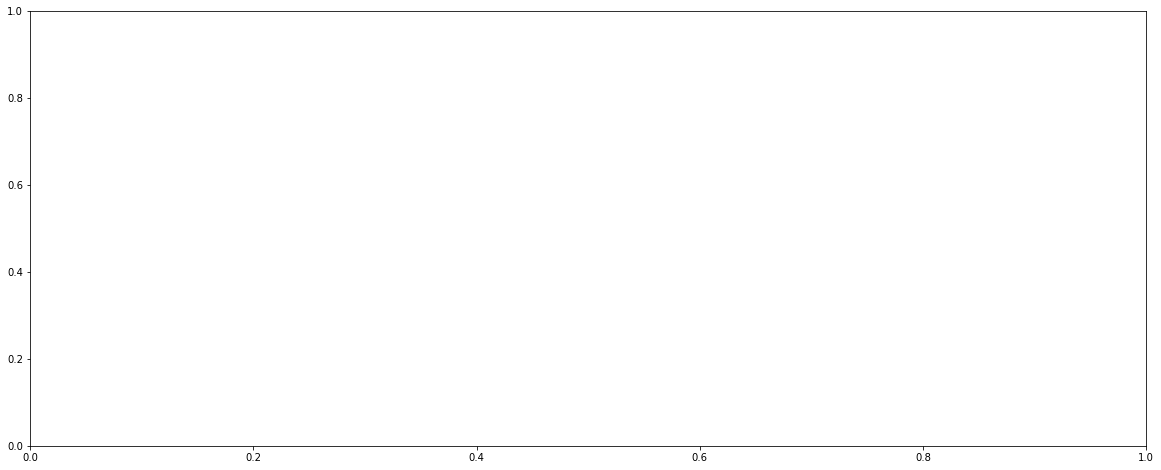

In [15]:
get_bounds(df)

for col in df:
    print(f"the range of col {col} is {df[col].min()} - {df[col].max()} ")

create1 = Creation(df,10000,['5'], weightingFunction='uniform')
pop1 = create1[0]
columns1 = pop1.columns.to_list()
columns1_drop = columns1.pop(-1)

labels1 = pop1.drop(columns1, axis=1)
pop1 = pop1.drop(columns1_drop, axis=1)
f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))
sns.scatterplot(pop1[:,0],pop1[:,1],ax=ax1)

Function For Experiments with bounds

**Fitness Function**

Requirements: Needs to be calced fast bc of multiple iterations
Posiibilities: - Binary Classification F1 Score, Mahalanobis Distance?
               - Other Types as well? : Linear Regression, Multiilabel Classification

Do we just impute our values and then do something similar to StudentPerformance and see what happens? No bc we need input from the fitness function to do our generations.

Is the data just our training set?
Inputs: Model(initialized outside function or inside?) fit with data that has been encoded and the label

Want to do kfold cv (not every loop bc very slow, once afterwards to evaluate)

when we do k fold, call fitness funciton k times i.e. once for every train test split.

if doing grid search, do it before calling this?

In [21]:
# calculates the fitness score for one train/test split dataset
# run on original dataset without random values first to be abe to compare


# def fitness(train_feat, test_feat, train_label, test_label, model):

#     model.fit(train_feat,train_label)
#     predictions = model.predict(test_feat) 

#     return f1_score(test_label, predictions, average='macro')

# def kfold_cv(n, feat, label):

#     kf = KFold(n_splits = n , random_state=None, shuffle=False)
#     for train_index, test_index in kf.split(df):
#         train_feat, test_feat = feat[train_index], feat[test_index]
#         train_label, test_label = label[train_index], label[test_index]

def fitness( model, feat, label, iterations, scorer):
    #scorer is the name of the function wee aree using to evaluate our dataset
    #it should be a function with signature scorer(model, feature, label) which should return only a single value.
    return cross_val_score(model, feat, label, cv = iterations, scoring = scorer)

def distance( x, y, metric):
    
    #get the distance between two sets of data x and y, they should be the same size
    #metric is the string metric to be used to measure distance

    dist = DistanceMetric.get_metric(metric)
    return dist.pairwise(x,y)

**Mutation**

In [22]:
def mutatePopulation (antiPopulation, bounds, binaryColumns : list):
    for col in antiPopulation:
        if col in binaryColumns: #Binary Columns must be handled differently than continuous
            antiPopulation[col] = antiPopulation[col].map(lambda x : (random.randint(0,1)))
        else:
            
            bnd_range = bounds[col][1] - bounds[col][0] #total range of bounds is high - low

            #Setting the low and high bounds to be centered around 0
            hi_bnd = bnd_range/2 
            low_bnd = (0-bnd_range/2)

            #print("Low bound around 0 = " + str(low_bnd) +"| Hi bnd around 0 = "+ str(hi_bnd))
            #print(round(random.uniform(low_bnd,hi_bnd),4))

            antiPopulation[col] = antiPopulation[col].map(lambda x : x+round(random.uniform(low_bnd,hi_bnd),4))
        
    return antiPopulation

#First round: Compare the base dataset, to the dataset+the created/mutated points
#

def comparePopulations(population1, population2, labels1, labels2, estimator, iterations, scorer):

    score1 = fmean(fitness(estimator, population1, labels1.values.ravel(), iterations, scorer))
    score2 = fmean(fitness(estimator, population2, labels2.values.ravel(), iterations, scorer))

    if score1 > score2:
        winning_population = population1
        winning_labels = labels1
    else:
        winning_population = population2
        winning_labels = labels2

    for col in winning_labels:
        winning_population = winning_population.join(winning_labels[col])

    return winning_population

def comparePopulations2(population1, population2, labels1, labels2, estimator, iterations, scorer):
    score1 = fmean(fitness(estimator, population1, labels1.values.ravel(), iterations, scorer))
    score2 = fmean(fitness(estimator, population2, labels2.values.ravel(), iterations, scorer))

    if abs(score1 - score2) < 0.005:
        return False
    elif (score1>score2):
        return False
    else:
        return True


In [23]:
create1 = Creation(df,10000,['5'], weightingFunction='uniform')
create2 = Creation(df,10000,['5'], weightingFunction='uniform')

pop1 = create1[0]
pop2 = create2[0]
bounds1 = create1[1]
bounds2 = create2[1]
columns1 = pop1.columns.to_list()
columns1_drop = columns1.pop(-1)

labels1 = pop1.drop(columns1, axis=1)
pop1 = pop1.drop(columns1_drop, axis=1)

columns2 = pop2.columns.to_list()
columns2_drop = columns2.pop(-1)

labels2 = pop2.drop(columns2, axis=1)
pop2 = pop2.drop(columns2_drop, axis=1)

In [24]:
pop2


,0,1,2,3,4
0,5.3983,4.1340,-6.9593,-4.7507,6.5841
1,4.3488,3.8093,-5.7476,-2.2695,3.5923
2,-5.6414,6.9509,-3.2704,-5.6022,2.9552
3,2.4092,6.4311,-6.4473,-6.3497,3.0976
4,-5.2475,7.5893,-8.1506,-6.6461,5.6094
...,...,...,...,...,...
9995,1.1023,8.7037,-7.8633,-7.9983,6.7833
9996,-6.7706,7.5637,-8.3169,-6.2198,4.5679
9997,-6.3296,4.5041,-1.8305,-7.3956,3.3847
9998,-4.1718,3.0365,-3.8261,-3.5738,5.5626


In [25]:
score1 = fmean(fitness(svm.SVC(random_state=0), pop1, labels1.values.ravel(), 5, 'f1_macro'))
score2 = fmean(fitness(svm.SVC(random_state=0), pop2, labels2.values.ravel(), 5, 'f1_macro'))

In [ ]:
print(score1)
print(score2)

0.4915367487110637
0.5030233667500458


In [111]:
comparePopulations2(pop1, pop2,labels1,labels2, svm.SVC(random_state=0), 5, 'f1_macro')

False

In [44]:
#separate a df into features and labels
def separate_df(df):

    columns = df.columns.to_list()
    columns_drop = columns.pop(-1)

    labels = df.drop(columns, axis=1)
    features = df.drop(columns_drop, axis=1)

    return features, labels

joe = pd.read_csv("./Data/GeneratedSyntheticData-NosielessInformativeEasy.csv")
feat,labels = separate_df(joe)
feat

,Unnamed: 0,0,1,2,3,4
0,0,-4.539317,5.021729,-7.042357,-7.428090,4.943687
1,1,4.300671,6.131065,-6.394796,-5.981102,4.579452
2,2,-5.004336,4.473384,-6.048647,-5.556982,4.051438
3,3,2.732848,7.791876,-7.495527,-6.541127,3.910933
4,4,-4.193859,5.393440,-5.317542,-5.605152,4.807354
...,...,...,...,...,...,...
295,295,5.349610,4.226061,-4.841005,-6.342083,4.820905
296,296,-5.247255,5.149173,-6.669314,-5.848687,3.793496
297,297,3.308685,5.513754,-3.805559,-5.564981,4.670373
298,298,-4.510472,4.712267,-4.550419,-3.915542,4.798225


In [140]:
def AIS(df,max_rounds):

    #change hardcoded
    #should be the minority df instead
    
    initial_population, bounds = Creation(df,10000,['5'], weightingFunction='uniform')
    
    antibody_population = mutatePopulation(initial_population,bounds,['5'])
    
    count = 0
    no_change = 0

    current_gen, current_labels = separate_df(initial_population)
    next_gen, next_labels = separate_df(antibody_population)
   
    while( (count<max_rounds) and (no_change < 5) ):
        count+=1

        #change hardcoded
        if(comparePopulations2(current_gen,next_gen,current_labels,next_labels,svm.SVC(random_state=0), 5, 'f1_macro')):
            
            no_change = 0

            current_gen = next_gen
            current_labels = next_labels

            current = current_gen
            current.append(current_labels)

            #need to update bounds
            antibody_population = mutatePopulation(current,bounds,['5'])
            next_gen, next_labels = separate_df(antibody_population)

            print('obama')
            print(current_labels)
            print(next_labels)
            count = 101

        else:

            no_change+=1
            # will this give the same thing every time?
            current_gen.append(current_labels)
            #current.co(current_labels)
            
            antibody_population = mutatePopulation(current_gen,bounds,['5'])
            next_gen, next_labels = separate_df(antibody_population)
            current_gen, current_labels = separate_df(current_gen)
            
            print('obamna')
            print(current_labels)
            print(current_gen)
            print(current)
            print(antibody_population)
            count = 101


    return current_gen, count
    

    

fd = pd.read_csv("./Data/GeneratedSyntheticData-NosiyEasy.csv")
x,y= AIS(df,100)
x


/var/folders/z_/sljvwrj965x1z1zxvjn2grhw0000gn/T/ipykernel_1149/1023100280.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current = current_gen.append(current_labels)


obamna
      5
0     1
1     1
2     1
3     1
4     0
...  ..
9995  1
9996  0
9997  1
9998  0
9999  1

[10000 rows x 1 columns]
           0        1        2       3       4
0    -2.9435  -0.7180   8.6596 -3.9961  1.0806
1     0.0434  -0.0019  -0.2853 -1.2285  0.2662
2     2.6306   8.0570  -2.8051 -2.0444 -3.1935
3    -0.8714 -15.5491 -17.1134  0.6552  1.3803
4    -2.4977   0.2552 -12.2166 -3.2293  0.7141
...      ...      ...      ...     ...     ...
9995 -0.1779   1.4311 -11.2348  3.4826  0.9704
9996  2.3779 -15.2503   5.9677  0.3027 -1.0446
9997  4.1802  -9.6459  -9.7535  0.3609 -1.3980
9998 -2.0005  -9.3382  -6.4946  0.9948 -0.9022
9999 -5.7449  12.1905   1.0485  2.0849 -0.5520

[10000 rows x 5 columns]
           0        1        2       3       4  5
0    -2.8158  -7.1472   8.1364 -5.5430  2.9494  1
1    -2.4750  -6.0691   3.4513 -0.6538 -0.5755  0
2     5.5332  15.1989   3.1198 -2.3882 -2.7601  1
3     2.1710 -10.4957 -15.7099  2.3097  3.8665  1
4    -2.1656   6.1051 -14.8714 

,0,1,2,3,4
0,-2.9435,-0.7180,8.6596,-3.9961,1.0806
1,0.0434,-0.0019,-0.2853,-1.2285,0.2662
2,2.6306,8.0570,-2.8051,-2.0444,-3.1935
3,-0.8714,-15.5491,-17.1134,0.6552,1.3803
4,-2.4977,0.2552,-12.2166,-3.2293,0.7141
...,...,...,...,...,...
9995,-0.1779,1.4311,-11.2348,3.4826,0.9704
9996,2.3779,-15.2503,5.9677,0.3027,-1.0446
9997,4.1802,-9.6459,-9.7535,0.3609,-1.3980
9998,-2.0005,-9.3382,-6.4946,0.9948,-0.9022


Evaluation

Use K-means clustering to identify clusteers with similar data. Use these clusters to perform K-fold cross validation and determin the useful clusters. Keep the best ones, discard the worst ones.

Question: How do we determine K?

 - Randomise certain groups of data in similar ways so we have an idea of how many clusters we have
 - Have the user choose the number of clusters by printing out a scatterplot
 - Find some way to estimate k before running k means
 - Use DBSCAN

In [86]:
dbscan_df = pd.read_csv("./Data/GeneratedSyntheticData-NosiyEasy.csv")

ss = StandardScaler()
dbscan_df = ss.fit_transform(dbscan_df)
dbs = DBSCAN(eps=1, min_samples=4)
dbs.fit(dbscan_df)
labels = dbs.labels_
core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
core_samples_mask[dbs.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_
#y_pred = dbs.fit_predict(dbscan_df)
# plt.scatter(dbscan_df[:,0], dbscan_df[:,1],c=y_pred, cmap='Paired')
# plt.title("DBSCAN")

#f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))
#sns.scatterplot(dbscan_df[:,0],dbscan_df[:,1],hue=y_pred,ax=ax1)

5

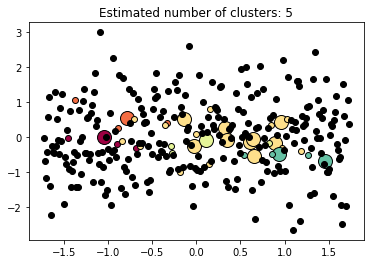

In [87]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = dbscan_df[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = dbscan_df[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

c:\Users\jacob\anaconda3\envs\csi4106\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

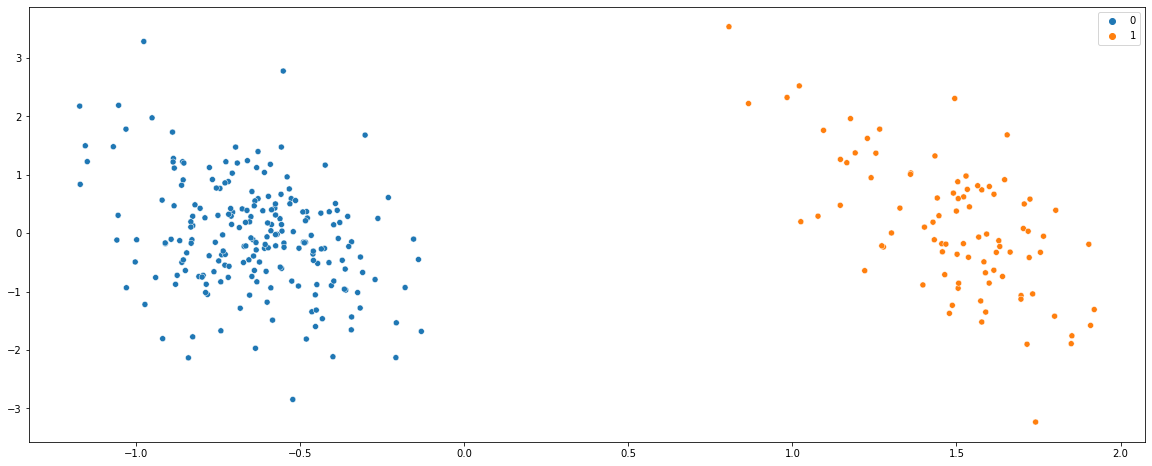

In [46]:
kmeans_df = pd.read_csv("./Data/GeneratedSyntheticData-NosielessInformativeEasy.csv")

ss = StandardScaler()
kmeans_df = ss.fit_transform(kmeans_df)
Kmean = KMeans(n_clusters=2)
Kmean.fit(kmeans_df)
y_pred = Kmean.predict(kmeans_df)
# plt.scatter(kmeans_df[:,0], kmeans_df[:,1],c=y_pred, cmap='Paired')
# plt.title("K-means")

f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))
sns.scatterplot(kmeans_df[:,0],kmeans_df[:,1],hue=y_pred,ax=ax1)

In [ ]:



randomForest = RandomForestClassifier()
#randomForest = randomForest.fit(df,labels)
clf = svm.SVC(random_state=0)

fitness(clf, df, labels.values.ravel(), 5, 'recall_macro')


array([0.65982906, 0.65413105, 0.68304843, 0.68490028, 0.67054264])